In [39]:
import pandas as pd
import json
import csv
import sys
import re
import string
import time
import numpy as np

import pandas as pd
from matplotlib.pylab import plt
from sklearn.decomposition import PCA

try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence

from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from collections.abc import Mapping
from collections.abc import MutableMapping
from collections.abc import Sequence

import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [40]:
from keras import layers
from tensorflow import keras
from keras.layers import Dense, Activation, Embedding, GlobalMaxPool1D, Dropout, Conv1D, Conv2D, LSTM, Flatten, BatchNormalization, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [41]:
from gensim.models import Word2Vec

In [42]:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

In [ ]:
!pip install optuna-integration

# Load the dataset

In [49]:
# load dataset
data_filepath = '/kaggle/input/cleaned-data/clean_dataset.json'

with open(data_filepath) as fp:
    dataset_json = json.load(fp)

# Get X and y values
#### The X values refers to the news text and y values refers to the labels (1-Real News, 0-Fake News)

In [50]:
# get x and y values
def get_x_y():
    X = []
    y = []

    for datapoint in dataset_json:
        y.append(datapoint['label'])
        X.append(datapoint['title_text'])

    return X, y


X, y = get_x_y()

### Convert the y values to int
#### The values are in str formated so they must be converted to int

In [51]:
# change y values to int
y = [eval(i) for i in y]

## Generate tokens for W2V Model

In [52]:
# create tokens
def create_tokens(sentence_list):
    token_data = []
    for sentence in sentence_list:
        tokens = word_tokenize(sentence)
        token_data.append(tokens)
    return token_data

In [53]:
tokenized_data = create_tokens(X)

In [54]:
print(f'Sample of the tokenized_data: {tokenized_data[1]}')

Sample of the tokenized_data: ['unbelievable', 'obamas', 'attorney', 'general', 'say', 'charlotte', 'rioter', 'peaceful', 'protesters…in', 'home', 'state', 'north', 'carolina', 'video', 'demonstrator', 'gathered', 'last', 'night', 'exercising', 'constitutional', 'protected', 'right', 'peaceful', 'protest', 'order', 'raise', 'issue', 'create', 'change', 'loretta', 'lynch', 'aka', 'eric', 'holder', 'skirt']


In [ ]:
lengths = [len(s) for s in tokenized_data]
# max length 
print(f'The maximum lenght from the list of sentences is: {max(lengths)}')

# Word2Vec Model

In [55]:
# word2vec model
start = time.time()
w2v_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=7, min_count=1)
print("Time taken to train word2vec model: ", round(time.time()-start, 0), 'seconds')

Time taken to train word2vec model:  141.0 seconds


In [56]:
vocab = w2v_model.wv.key_to_index
print("The total words : ", len(vocab))
vocab = list(vocab.keys()) # list of the words in the model

The total words :  354786


In [57]:
print(vocab[10:30])

['year', 'time', 'also', 'republican', 'like', '—', 'say', 'american', 'government', 'could', 'country', 'house', 'obama', 'election', 'campaign', 'donald', 'even', 'two', 'united', 'hillary']


### Create a word to vector dictionary 

In [58]:
def create_word_vect_dict(vocab):
    wv_dict = {}
    for word in vocab:
        wv_dict[word] = w2v_model.wv.get_vector(word)
    return wv_dict

In [59]:
word_vect_dict = create_word_vect_dict(vocab)

In [60]:
print(f'Word: {list(word_vect_dict.keys())[2]}')
print(f'Vector: {list(word_vect_dict.values())[2]}')

Word: state
Vector: [-1.1177679  -0.11347562 -2.2373407  -2.057181    0.886795    4.810345
  0.00765634 -4.5547915  -0.6272589   0.52087075 -1.7627382   1.8469561
  2.1541176   1.0721799   3.1037207  -2.4945946   2.059523    3.6729085
 -0.53622544  4.198242   -0.9413106  -5.8069353  -5.4322023  -1.3270738
 -1.4101251  -1.2483879   1.1852399  -1.5536494  -1.5636048  -2.8840184
 -3.0862298  -1.3782889   0.56835496 -1.7063116  -3.5331888  -0.713162
 -2.9777353   1.6294383  -1.3747898   3.973588    1.0341909   3.4230468
  1.1672075   1.0795965   1.5952733   3.385461   -2.0419462   0.41753387
 -0.77445924 -5.452037    0.24621919  1.9540025   1.6600204   1.1907865
 -5.0640025   0.13258876 -0.5643163  -1.684224    1.9296312   2.7928715
 -0.10359181 -1.8592095   1.6806011   2.342358   -0.5786413  -0.27826646
 -0.0577146   0.8896015   0.30342653 -6.452884    6.266134    0.6320498
  1.7979906  -0.41526422  2.1000483   4.2047434   3.6868958  -1.1193124
 -2.5861301  -1.3683481   1.9620749  -3.6612

### Take a look at the similar words after training the W2V model

In [61]:
w2v_model.wv.most_similar("obama")

[('obamas', 0.8785530924797058),
 ('obamasrinivasan', 0.7730119824409485),
 ('obamasince', 0.7636562585830688),
 ('somedvillagetty', 0.7619410753250122),
 ('obama…enjoy', 0.7339611649513245),
 ('paintand', 0.7313613295555115),
 ('obamathe', 0.7264833450317383),
 ('obamaobama', 0.7244993448257446),
 ('obama—took', 0.7204617857933044),
 ('obamabefore', 0.7161855101585388)]

In [62]:
w2v_model.wv.most_similar("facebook")

[('snapchat', 0.7190301418304443),
 ('instagram', 0.6872009038925171),
 ('reddit', 0.6770830154418945),
 ('facebooks', 0.6764742732048035),
 ('twitter', 0.6733623147010803),
 ('gpaccording', 0.6311611533164978),
 ('user', 0.6306385397911072),
 ('website', 0.6285021305084229),
 ('online', 0.6231210231781006),
 ('google', 0.6082382798194885)]

In [63]:
# encode the text and define parameters (tokenize the text)
# fit_on_texts Updates internal vocabulary based on a list of texts.
# This method creates the vocabulary index based on word frequency.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [64]:
# encoded news title-text with mathematical index
X = tokenizer.texts_to_sequences(X) 
# lets check first 15 words of the first news
X[0][:15]

[44, 617, 309, 3204, 416, 330, 1419, 33, 8580, 63110, 347, 79, 157, 469, 427]

In [65]:
# look at the words and its numerical representation
word_index = tokenizer.word_index
for word, index in word_index.items():
    print(f'{word}: {index}')
    if index == 5:
        break

said: 1
trump: 2
state: 3
would: 4
people: 5


In [66]:
# keep all the news to 1000, pad news with less than 1000 words and trunacate the longer sentences
max_length = 1000

In [67]:
print(f'Length before padding: {len(X[0])}')
# pad the sequence 
X_pad = pad_sequences(X, maxlen=max_length, padding='post')
print(f'After padding: {len(X_pad[0])}')

Length before padding: 468
After padding: 1000


In [68]:
vocab_size = len(tokenizer.word_index) + 1
print(f'vocabulary size: {vocab_size}')

vocabulary size: 360087


### Create the embedding matrix for the embedding layer 

In [69]:
def get_embedding_matrix(model, vocab, embed_dimensions):
    hits = 0
    misses = 0
    
    vocab_size = len(vocab) + 1
    
    embed_matrix = np.zeros((vocab_size, embed_dimensions))
    
    for word, i in vocab.items():
        try:
            if word_vect_dict is not None:
                embed_matrix[i] = model.wv[word]
                hits += 1
            else:
                misses +=1
        except:
            pass
    
    print(f'converted words {hits} ({misses} missed words)')
    return embed_matrix

In [70]:
embed_dim = 100
embed_matrix = get_embedding_matrix(w2v_model, word_index, embed_dim)

converted words 353618 (0 missed words)


# Define the neural Network

In [71]:
# define a simple lstm neural network
def lstm_model():
    model = Sequential()

    model.add(Embedding(vocab_size, embed_dim, input_length=max_length, 
                        weights=[embed_matrix], trainable=False))

    model.add(LSTM(128))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
    
    return model

lstm_model = lstm_model()
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         36008700  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36126077 (137.81 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 36008700 (137.36 MB)
_________________________________________________________________


In [ ]:
def cnn_model():
    model = Sequential()

    model.add(Embedding(vocab_size, embed_dim, input_length=max_length, weights=[embed_matrix], trainable=False))
    
    model.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
    
    return model

model = cnn_model()
model.summary()

## split the data into training and testing

In [72]:
y_array = np.array(y)

In [73]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_array, test_size=0.2) 

In [74]:
# monitor the loss and patience set to 5 where the triaining will be stopped if no improvedment are seen after 3 epochs
callback = EarlyStopping(monitor='loss', patience=5)

In [75]:
filepath = 'lstm_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [76]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [77]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=12, batch_size=16, 
                         validation_split=0.1, 
                         callbacks=[callback, checkpoint], shuffle=True)

In [78]:
history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=16, 
                         validation_split=0.1, 
                         callbacks=[callback, checkpoint], shuffle=True)

Epoch 1/15
3219/3220 [============================>.] - ETA: 0s - loss: 0.6852 - precision_1: 0.5140 - recall_1: 0.7306
Epoch 1: val_loss improved from inf to 0.67998, saving model to lstm_best_model.epoch01-loss0.68.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3220/3220 [==============================] - 100s 30ms/step - loss: 0.6852 - precision_1: 0.5140 - recall_1: 0.7306 - val_loss: 0.6800 - val_precision_1: 0.5237 - val_recall_1: 0.9997
Epoch 2/15
3219/3220 [============================>.] - ETA: 0s - loss: 0.6141 - precision_1: 0.6229 - recall_1: 0.7657
Epoch 2: val_loss improved from 0.67998 to 0.58504, saving model to lstm_best_model.epoch02-loss0.59.hdf5
3220/3220 [==============================] - 98s 30ms/step - loss: 0.6141 - precision_1: 0.6229 - recall_1: 0.7657 - val_loss: 0.5850 - val_precision_1: 0.8098 - val_recall_1: 0.5984
Epoch 3/15
3219/3220 [============================>.] - ETA: 0s - loss: 0.5604 - precision_1: 0.7246 - recall_1: 0.7469
Epoch 3: val_loss did not improve from 0.58504
3220/3220 [==============================] - 98s 30ms/step - loss: 0.5604 - precision_1: 0.7246 - recall_1: 0.7469 - val_loss: 0.6034 - val_precision_1: 0.6762 - val_recall_1: 0.8146
Epoch 4/15
3219/3220 [============================>.] - E

In [79]:
lstm_score = lstm_model.evaluate(X_test, y_test)
print(f'{lstm_model.metrics_names[0]}: {lstm_score[0]}')
print(f'{lstm_model.metrics_names[1]}: {lstm_score[1]}')
print(f'{lstm_model.metrics_names[2]}: {lstm_score[2]}')

448/448 [==============================] - 10s 22ms/step - loss: 0.0694 - precision_1: 0.9769 - recall_1: 0.9832
loss: 0.06936707347631454
precision_1: 0.976861298084259
recall_1: 0.9831506609916687


In [ ]:
score = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[0]}: {score[0]}')
print(f'{model.metrics_names[1]}: {score[1]}')
print(f'{model.metrics_names[2]}: {score[2]}')

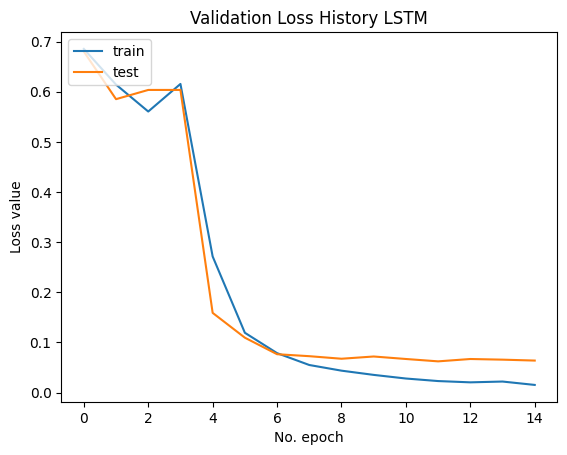

In [80]:
# plot the history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation Loss History LSTM')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(f'Loss({lr}-{batch_size}).png')
plt.show()


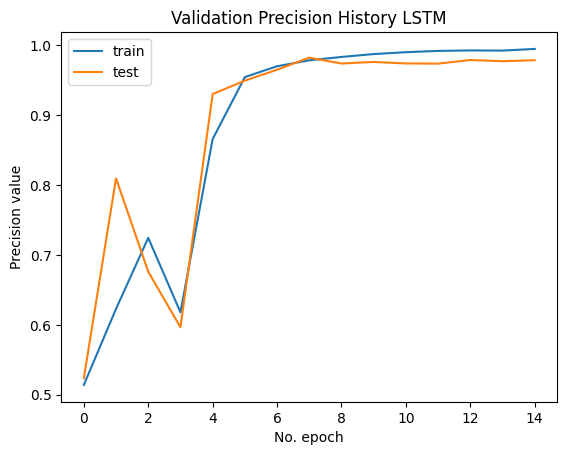

In [86]:
plt.plot(history.history['precision_1'], label="precision")
plt.plot(history.history['val_precision_1'])
plt.title('Validation Precision History LSTM')
plt.ylabel('Precision value')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

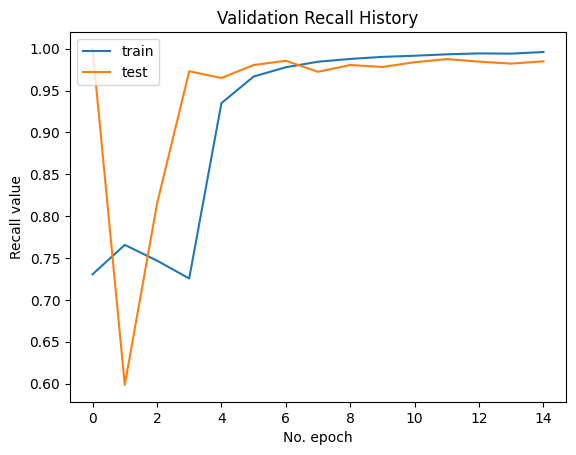

In [87]:
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Validation Recall History')
plt.ylabel('Recall value')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
# save tokenizer
with open('lstm_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('saved keras tokenizer')

saved keras tokenizer


# OPTUNA - Hyperparameter Tuning
#### Optuna is a hyperparamter optimization framework 

In [99]:
def objective(trial):
    # clear clutter from previous sessions
    keras.backend.clear_session()

    # best number of hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)

    # parameters
    dropouts = trial.suggest_float(f'dropout', 0.0, 0.7)
    # filters = trial.suggest_categorical(f'filters', [x for x in range(8, 400)])
    # kernel_sizes = trial.suggest_categorical(f'kernel_sizes', [2, 3, 4])
    # stride = trial.suggest_int(f'strides', 1, 2)

    # --- create trial optuna model ---
    opt_model = keras.Sequential()
    # embedding
    opt_model.add(Embedding(vocab_size, embed_dim, input_length=max_length, weights=[embed_matrix], trainable=False))

    # opt_model.add(Dropout(rate=dropouts))

    # optimize multiple convolution layers
    for i in range(n_layers):
        # num_hidden = trial.suggest_int(f'n_units_l{i}', 48, 215, log=True)
        # activation_choice = trial.suggest_categorical('activation', ['relu', 'linear'])

        # optimize conv1d parameters
        opt_model.add(Conv1D(filters=trial.suggest_categorical(f'filters{i}', [x for x in range(8, 400)]),
                             kernel_size=trial.suggest_categorical(f'kernel_sizes{i}', [2, 3, 4]),
                             strides=trial.suggest_int(f'strides{i}', 1, 2),
                             padding='valid',
                             activation='relu'))
        
#         opt_model.add(LSTM(units=trial.suggest_categorical(f'units{i}', [64, 128, 256]), return_sequences=True))

        # optimize for each layer dropouts
#         opt_model.add(Dropout(rate=trial.suggest_float(f'dropout{i}', 0.0, 0.7)))

    opt_model.add(Flatten())

    # output layer
    opt_model.add(Dense(1, activation='sigmoid'))

    # reduce learning rate if it shows no signs of improvement
    rdc_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-05, verbose=0)

    # early stop - stop if the model stops improving
    early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=0, mode="auto",
                               baseline=None,
                               restore_best_weights=True)

    # compile the model and get best learning rate
    learning_rate = keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-7, 1e-2, log=True))
    opt_model.compile(loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall()], optimizer=learning_rate)

    # fit the model and calculate the best batch size
    opt_histroy = opt_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=11, callbacks=[rdc_lr, early_stop],
                                verbose=0, batch_size=trial.suggest_int('size', 8, 128))

    val_loss = min(opt_histroy.history['val_loss'])
    val_recall = max(opt_histroy.history['val_recall'])
    val_precision = max(opt_histroy.history['val_precision'])

    return val_precision

### create a study for optimization

### CNN Model Optimization
##### CNN model optimization with 1 - 3 layers and its hyperparameters
##### The results shows the best parameters for optimizing precision

##### The results below are the 10 trials after running 20 epochs per trial
##### Trial 9 finished with value: 0.9881691932678223 and parameters: {'n_layers': 2, 'dropout': 0.05683856356964569, 'filters0': 242, 'kernel_sizes0': 2, 'strides0': 2, 'filters1': 161, 'kernel_sizes1': 4, 'strides1': 2, 'learning_rate': 0.0007263120247350704, 'size': 42}. Best is trial 9 with value: 0.9881691932678223.

##### The results below are the 15 trials after running 11 epochs per trial
##### Trial 0 finished with value: 0.9813281297683716 and parameters: {'n_layers': 3, 'dropout': 0.3252078256056102, 'filters0': 160, 'kernel_sizes0': 2, 'strides0': 2, 'filters1': 180, 'kernel_sizes1': 2, 'strides1': 2, 'filters2': 337, 'kernel_sizes2': 3, 'strides2': 2, 'learning_rate': 0.00199622031294333, 'size': 44}. Best is trial 0 with value: 0.9813281297683716.

##### The results below are the 15 trials after running 6 epochs per trial

In [100]:
# study = optuna.create_study(directions=['maximize', 'maximize'])
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=None)

[I 2024-02-23 10:56:12,414] A new study created in memory with name: no-name-b5b83cef-27d7-4476-ad11-8a8fbf1fe6ff
[I 2024-02-23 10:57:50,995] Trial 0 finished with value: 0.9626533389091492 and parameters: {'n_layers': 2, 'dropout': 0.3935490097457354, 'filters0': 105, 'kernel_sizes0': 4, 'strides0': 1, 'filters1': 286, 'kernel_sizes1': 4, 'strides1': 2, 'learning_rate': 0.00016006700858678196, 'size': 82}. Best is trial 0 with value: 0.9626533389091492.
[I 2024-02-23 10:59:59,105] Trial 1 finished with value: 0.9750339388847351 and parameters: {'n_layers': 2, 'dropout': 0.270560377502416, 'filters0': 295, 'kernel_sizes0': 3, 'strides0': 2, 'filters1': 180, 'kernel_sizes1': 3, 'strides1': 2, 'learning_rate': 0.0010925318771320468, 'size': 18}. Best is trial 1 with value: 0.9750339388847351.
[I 2024-02-23 11:01:56,945] Trial 2 finished with value: 0.9851144552230835 and parameters: {'n_layers': 2, 'dropout': 0.2115149384793766, 'filters0': 153, 'kernel_sizes0': 3, 'strides0': 1, 'filter

KeyboardInterrupt: 

In [101]:
# optimization History
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
# Visualize the loss curves of the trials
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

In [95]:
# visualize the best params
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [96]:
def single_metric_stats(study):
    # --- stats for single metrics ---
    print('--- Study statistics for CNN Model ---')
    print(f"Number of completed trials: {len(study.trials)}")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best trial value: {study.best_trial.value}")
    print("  Best Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
single_metric_stats(study)

--- Study statistics for CNN Model ---
Number of completed trials: 15
Best trial: 0
Best trial value: 0.9813281297683716
  Best Params: 
    n_layers: 3
    dropout: 0.3252078256056102
    filters0: 160
    kernel_sizes0: 2
    strides0: 2
    filters1: 180
    kernel_sizes1: 2
    strides1: 2
    filters2: 337
    kernel_sizes2: 3
    strides2: 2
    learning_rate: 0.00199622031294333
    size: 44


### LSTM Model Optimization
##### LSTM model optimization with 1 - 3 layers and its hyperparametet
##### The results below are the trials after running 20 epochs per trial
##### The results shows the best parameters for optimizing precision and recall
#####  Trial 0 finished with values: [0.974801242351532, 0.9943812489509583] and parameters: {'n_layers': 1, 'dropout': 0.33222106033748494, 'units0': 128, 'learning_rate': 0.002286849245208628, 'size': 62}.

In [ ]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10, timeout=None)

### Returns the best hyperparameters for the model

In [ ]:
single_metric_stats(study)

# Hybrid Model (CNN - Bidirectional LSTM)

In [ ]:
hybrid_model = Sequential()

hybrid_model.add(Embedding(vocab_size, embed_dim, input_length=max_length, weights=[embed_matrix], trainable=False))
hybrid_model.add(Dropout(0.4))

hybrid_model.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))

hybrid_model.add(Bidirectional(LSTM(128, dropout=0.4, return_sequences=True)))

hybrid_model.add(Flatten())

hybrid_model.add(Dense(1, activation='sigmoid'))
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

hybrid_model.summary()

In [ ]:
history_hybrid = hybrid_model.fit(X_train, y_train, validation_split=0.3, epochs=11)

In [ ]:
# hybrid model evaluation 
hybrid_score = hybrid_model.evaluate(X_test, y_test)
print(f'{hybrid_model.metrics_names[0]}: {hybrid_score[0]}')
print(f'{hybrid_model.metrics_names[1]}: {hybrid_score[1]}')
print(f'{hybrid_model.metrics_names[2]}: {hybrid_score[2]}')